Code from the MXNet ["Handwritten Digit Recognition"][0] Tutorial.

  [0]: https://mxnet.incubator.apache.org/tutorials/python/mnist.html

__Building the Network__

In [1]:
import mxnet as mx
mnist = mx.test_utils.get_mnist()
batch_size = 100
train_iter = mx.io.NDArrayIter(mnist['train_data'], mnist['train_label'], batch_size, shuffle=True)
val_iter = mx.io.NDArrayIter(mnist['test_data'], mnist['test_label'], batch_size)

data = mx.sym.var('data')
data = mx.sym.flatten(data=data)

fc1 = mx.sym.FullyConnected(data=data, num_hidden=128)
act1 = mx.sym.Activation(data=fc1, act_type='relu')

fc2 = mx.sym.FullyConnected(data=act1, num_hidden=64)
act2 = mx.sym.Activation(data=fc2, act_type='relu')

fc3 = mx.sym.FullyConnected(data=act2, num_hidden=10)
mlp = mx.sym.SoftmaxOutput(data=fc3, name='softmax')

__Training the Network__

In [2]:
import logging
logging.getLogger().setLevel(logging.DEBUG)

mlp_model = mx.mod.Module(symbol=mlp, context=mx.cpu())
mlp_model.fit(
  train_iter,
  eval_data=val_iter,
  optimizer='sgd',
  optimizer_params={'learning_rate': 0.1},
  eval_metric='acc',
  batch_end_callback = mx.callback.Speedometer(batch_size, 100),
  num_epoch=10
)

INFO:root:Epoch[0] Batch [100]	Speed: 44627.57 samples/sec	accuracy=0.115347
INFO:root:Epoch[0] Batch [200]	Speed: 46540.60 samples/sec	accuracy=0.113600
INFO:root:Epoch[0] Batch [300]	Speed: 13488.11 samples/sec	accuracy=0.111700
INFO:root:Epoch[0] Batch [400]	Speed: 19022.79 samples/sec	accuracy=0.110000
INFO:root:Epoch[0] Batch [500]	Speed: 26835.77 samples/sec	accuracy=0.109700
INFO:root:Epoch[0] Train-accuracy=0.217475
INFO:root:Epoch[0] Time cost=2.344
INFO:root:Epoch[0] Validation-accuracy=0.264000
INFO:root:Epoch[1] Batch [100]	Speed: 42226.25 samples/sec	accuracy=0.419703
INFO:root:Epoch[1] Batch [200]	Speed: 48638.58 samples/sec	accuracy=0.599800
INFO:root:Epoch[1] Batch [300]	Speed: 49223.09 samples/sec	accuracy=0.752500
INFO:root:Epoch[1] Batch [400]	Speed: 46930.22 samples/sec	accuracy=0.801000
INFO:root:Epoch[1] Batch [500]	Speed: 44810.37 samples/sec	accuracy=0.825100
INFO:root:Epoch[1] Train-accuracy=0.852424
INFO:root:Epoch[1] Time cost=1.344
INFO:root:Epoch[1] Validat

__Testing the Network's Accuracy__

In [3]:
test_iter = mx.io.NDArrayIter(mnist['test_data'], mnist['test_label'], batch_size)
acc = mx.metric.Accuracy()
mlp_model.score(test_iter, acc)
print(acc)
assert acc.get()[1] > 0.96

EvalMetric: {'accuracy': 0.97170000000000001}


__Plot network weights and biases__

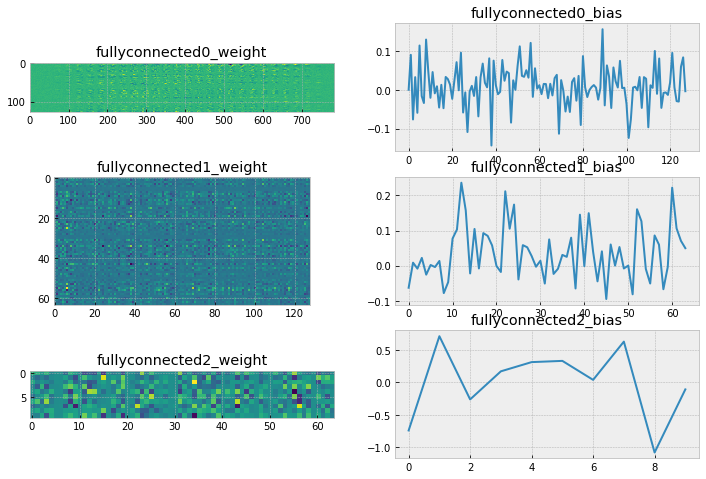

In [4]:
%matplotlib inline
from matplotlib import gridspec
from matplotlib import pyplot as plt
from matplotlib import style
style.use('bmh')

# Extract weights and biases.
w1 = mlp_model._arg_params[fc1.name + '_weight'].asnumpy()
w2 = mlp_model._arg_params[fc2.name + '_weight'].asnumpy()
w3 = mlp_model._arg_params[fc3.name + '_weight'].asnumpy()
b1 = mlp_model._arg_params[fc1.name + '_bias'].asnumpy()
b2 = mlp_model._arg_params[fc2.name + '_bias'].asnumpy()
b3 = mlp_model._arg_params[fc3.name + '_bias'].asnumpy()

fig = plt.figure()
fig.set_size_inches(12, 8)
grid_outer = gridspec.GridSpec(1, 2)
grid_left = gridspec.GridSpecFromSubplotSpec(3, 1, subplot_spec=grid_outer[0])
grid_right = gridspec.GridSpecFromSubplotSpec(3, 1, subplot_spec=grid_outer[1])

for i, (sym, w) in enumerate(zip([fc1, fc2, fc3], [w1, w2, w3])):
  ax = fig.add_subplot(grid_left[i])
  ax.set_title(sym.name + '_weight')
  ax.imshow(w)
  
for i, (sym, b) in enumerate(zip([fc1, fc2, fc3], [b1, b2, b3])):
  ax = fig.add_subplot(grid_right[i])
  ax.set_title(sym.name + '_bias')
  ax.plot(b)

plt.show()

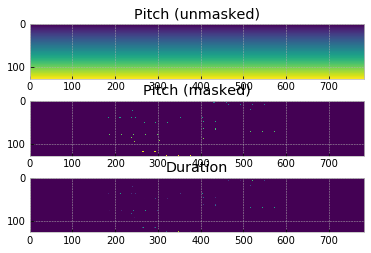

/home/niklas/Desktop/notebooks/Sonification/Neural Net MNIST/out.mid

In [5]:
import numpy as np

BPM = 120
VOLUME = 100
NOTE_MIN = 36   # C3
NOTE_MAX = 95   # B7
THRESHOLD = 0.85

# >> Convert a layer weight to MIDI.
# Normalize the weight range to 0-1.
w = w1.copy()
w = (w - np.min(w)) / (np.max(w) - np.min(w))

# Pitches, masked by a threshold in the weights.
# The pitches are distributed evenly, only activated by
# a threshold in the weights.
ps = np.tile([np.linspace(NOTE_MIN, NOTE_MAX, w.shape[0])], (w.shape[1], 1))
pm = ps.copy()
pm[w.T < THRESHOLD] = -1
pm = pm.astype(np.int8)

# Note durations (in beats).
d = (w.T - THRESHOLD) / (1.0 - THRESHOLD)
d[d < 0.0] = 0.0


# The masked gradient is similar to what you will see in the MIDI editor.
axs = plt.subplots(3, 1)[1]
axs[0].imshow(ps.T); axs[0].set_title('Pitch (unmasked)')
axs[1].imshow(pm.T); axs[1].set_title('Pitch (masked)')
axs[2].imshow(d.T); axs[2].set_title('Duration')
plt.show()

# Write the MIDI file.
from midiutil.MidiFile import MIDIFile
midi = MIDIFile(1, adjust_origin=True)  # 1 track
midi.addTempo(0, 0, BPM)
for i in range(pm.shape[0]):
  t = i / 10
  for j in range(pm.shape[1]):
    if pm[i][j] >= 0:
      midi.addNote(0, 0, pm[i][j], t, d[i][j] * 4, VOLUME)
with open('out.mid', 'wb') as fp:
  midi.writeFile(fp)
from IPython.display import display, FileLink
display(FileLink('out.mid'))